# Microsoft's Foray Into the Movie World
Flatiron School Data Science: Project 1
- **Author**: Zaid Shoorbajee
- **Instructor**: Matt Carr
- **Pace**: Flex, 20 weeks

## Overview

This project analyzes data about the ratings and popularity of movies to make recommendations to Microsoft, which intends to launch its own movie studio. As a newcomer to the scene, Microsoft has asked for recommendations on what types of movies perform well among audiences. I have available to me movie datasets from Box Office Mojo, IMDb, Rotten Tomatoes, The Movie Database, and The Numbers. I derive my conclusions mainly from the **IMDb datasets**, which contain information about movies from 2010 to 2019, including, genres, average user rating, and the number of users who voted on each movie. As a result of the analysis, I was able to distill 10 well-peforming genres for Microsoft to focus on, as well as make recommendations about how much of its budget it should focus on 1) comedies and 2) animated movies.

## Business Problem

**Measuing success:** A first instict might be to narrow down the attributes of movies that have the highest return-on-investment at the box office. However, in the streaming age, that might not be the best measure of success. Popular movies are increasingly being [released directly to streaming services](https://variety.com/2022/film/box-office/disney-pixar-turning-red-disney-plus-subscribers-1235149836/), and the COVID-19 pandemic has dissuaded many people from going to the theaters anymore. A better measure of success would be the number of people that will actually watch the movie. Whether Microsoft plans to sell its movies to distributors like Netflix or spin up its own streaming service to host the films, it needs to determine what kinds of movies are going to attract the most viewers in numbers.

I use the **number of votes a movie has received** on IMDb as an analogue for the number of viewers. The votes may be negative or positive, but we can infer that a vote means someone actually watched the film. Using this metric, I attempt to answer these questions:

- Which 10 genres tend to perform best?
- How much should Microsoft focus on making comedies? 
- How much should Microsoft focus on making animated movies?

## Data Understanding

IMDb is one of the most popular websites for basic facts about movies and TV shows, as well as user reviews. It claims to have nearly [600,000 movies](https://www.imdb.com/pressroom/stats/) listed and is [ranked 75th](https://www.alexa.com/siteinfo/imdb.com) in in global internet engagement. 

The data I've been provided is housed in a SQL file, from which I primarily use two tables:
- `movie_basics`: Contains information about each movie's name, release year, runtime, and genres.
- `movie_ratings`: Contains a weighted average of all the individual user ratings and the number of votes a movie has received.

More information [here](https://www.imdb.com/interfaces/).

The two tables have a shared column `movie_id`, which is a unique identifier for each movie. I plan to group movies by genre to to see each genre's average rating and and average number of votes.

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
%matplotlib inline

In [2]:
! ls zippedData

bom.movie_gross.csv.gz
im.db
im.db.zip
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


## Data Preparation

#### Exloring the SQL database for IMDb

In [3]:
with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
    zipfile.ZipFile.extractall(my_zip, path='ZippedData')
    
# Created a new file called im.db
# Added the file to .gitignore because it's too big to upload to GitHub

In [4]:
con = sqlite3.connect('zippedData/im.db')

In [5]:
pd.read_sql("""
SELECT *
FROM sqlite_schema
WHERE type='table'
""", con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


### Merging the IMDb `movie_basics` and `movie_ratings` files:

In [6]:
movies_w_ratings_imdb = pd.read_sql("""
SELECT * FROM movie_basics
LEFT JOIN movie_ratings
    USING(movie_id)
""" , con)

In [7]:
# Preivew the resulting DataFrame
movies_w_ratings_imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0


In [8]:
movies_w_ratings_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   averagerating    73856 non-null   float64
 7   numvotes         73856 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 8.9+ MB


In [9]:
# Calculating the number of null values

movies_w_ratings_imdb.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
averagerating      72288
numvotes           72288
dtype: int64

In [10]:
# Seeing the proportion of rows with null values

movies_w_ratings_imdb.isna().sum()/len(movies_w_ratings_imdb)

movie_id           0.000000
primary_title      0.000000
original_title     0.000144
start_year         0.000000
runtime_minutes    0.217176
genres             0.037005
averagerating      0.494635
numvotes           0.494635
dtype: float64

### There are several columns with null data to contend with.
Let's start with the `averagerating` and `numvotes` columns.

In [11]:
# Confirming that the two columns are null in all the same rows

movies_w_ratings_imdb.isna()['averagerating'].equals(movies_w_ratings_imdb.isna()['numvotes'])

True

### Below, we view a sample of the titles where there are no ratings or votes.

They appear to be mostly niche titles, many with missing runtimes or runtimes under one hour. They are not representative of the content Microsoft wants to promote as it debuts its streaming service.

Although they make up about half the dataset, we are not likely to derive any meaningful insight from these titles. Keeping them would disrupt our analysis and there's no value we can replace them with. For these reasons we'll drop these rows. Fortunately, our dataset will still have about 70,000 entries to work with.

In [12]:
NaN_movies_w_ratings_imdb = movies_w_ratings_imdb[
    movies_w_ratings_imdb['numvotes'].isna()
    ]

In [13]:
NaN_movies_w_ratings_imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,NaN,NaN
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History",NaN,NaN
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography,NaN,NaN
16,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,NaN,None,NaN,NaN
25,tt0262759,Seven Jews from My Class,Siedmiu Zydów z mojej klasy,2018,40.0,Documentary,NaN,NaN


In [14]:
# Dropping titles with no votes or rating

movies_w_ratings_imdb.dropna(subset=['numvotes'], inplace=True)

In [15]:
# confirming that this worked for both the numvotes and averagerating columns:

print('Number of null ratings:',
      movies_w_ratings_imdb['averagerating'].isnull().sum()
     )

print('Number of null vote counts:',
      movies_w_ratings_imdb['numvotes'].isnull().sum()
     )

Number of null ratings: 0
Number of null vote counts: 0


In [16]:
# Reminding myself of the basic info in the dataset 
movies_w_ratings_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 146134
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 5.1+ MB


In [17]:
movies_w_ratings_imdb.isna().sum()/len(movies_w_ratings_imdb)

movie_id           0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
runtime_minutes    0.103174
genres             0.010886
averagerating      0.000000
numvotes           0.000000
dtype: float64

### In the remaining dataset, about 1 percent of the titles are missing genres. 
#### Since genres are going to be central to our recommendations, I'll drop those rows, too.

In [18]:
# Dropping titles with no genres listed.

movies_w_ratings_imdb.dropna(subset=['genres'], inplace=True)

### Dealing with duplicates

In [19]:
movies_w_ratings_imdb.duplicated().sum()

0

In [20]:
movies_w_ratings_imdb.duplicated(subset='original_title').sum()

2707

There are more than 2,700 movies with the same name. But that doesn't mean they're duplicates. It could just be a coincidence.

Let's see if there are movies with the same name, runtime, and year.

In [21]:
movies_w_ratings_imdb[
    movies_w_ratings_imdb.duplicated(
        subset=['original_title',
                'runtime_minutes', 
                'start_year'
               ]
    )
]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
2658,tt10275936,Raggarjävlar (Swedish Greasers),Raggarjävlar (Swedish Greasers),2019,70.0,Documentary,6.9,47.0
11830,tt1644694,The Gift,The Gift,2010,NaN,"Animation,Drama",5.9,7.0
12984,tt1674217,Transit,Transit,2010,80.0,"Biography,Documentary,Family",6.7,13.0
19111,tt1825978,The Artist,The Artist,2011,100.0,Thriller,6.8,6.0
23887,tt1967651,Unconditional Love,Unconditional,2012,92.0,"Drama,Thriller",5.6,660.0
24139,tt1977822,Inside,Inside,2012,85.0,Horror,4.0,397.0
33380,tt2246595,Blood Money,Blood Money,2012,109.0,"Action,Drama,Thriller",5.2,881.0
37698,tt2363471,The Summit,The Summit,2012,95.0,"Adventure,Documentary",6.9,4147.0
47280,tt2805202,Rise of the Undead,Rise of the Undead,2013,70.0,Action,4.2,20.0
50941,tt3019098,The Last Act,The Last Act,2012,NaN,Thriller,5.7,6.0


**We should delete the duplicates, but we should keep the version with the higher vote count, as it's the version that IMDb users will more likely come across.**

In [22]:
# Sorting the dataset by vote count

movies_w_ratings_imdb.sort_values(
    by='numvotes',
    ascending=False, 
    inplace=True
)

In [23]:
# Dropping the duplicates

movies_w_ratings_imdb.drop_duplicates(
    subset=[
        'original_title', 
        'runtime_minutes', 
        'start_year'
    ], 
    inplace=True, 
    keep='first'
)

In [24]:
movies_w_ratings_imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"Action,Thriller",8.4,1387769.0
311,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334.0
20342,tt1853728,Django Unchained,Django Unchained,2012,165.0,"Drama,Western",8.4,1211405.0
356,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655.0


### Dealing with the `genres` column:

The values in the genres column contain multiple genres separated by a comma. I'll need to split them up them somehow.

I can use the **`df.explode()`** method to separate them. But first I'll need to convert the value from a string to an list.

In [25]:
# Creating a new dataframe because I may want to use this one in a later analysis.

clean_genres = movies_w_ratings_imdb.copy()

In [26]:
# Changing each entry in 'genres' from a string into a list

clean_genres['genres'] = clean_genres['genres'].str.split(',')

In [27]:
clean_genres.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,"[Action, Adventure, Sci-Fi]",8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"[Action, Thriller]",8.4,1387769.0
311,tt0816692,Interstellar,Interstellar,2014,169.0,"[Adventure, Drama, Sci-Fi]",8.6,1299334.0


In [28]:
# Creating a list of all unique genres, now that we can iterate through them.

genres_all = set()
genres_column = clean_genres['genres']

for glist in genres_column:
    for g in glist:
        genres_all.add(g)

In [29]:
print(f'There are {len(genres_all)} genres in our IMDb dataset. They are:\n\n {genres_all}.')

There are 26 genres in our IMDb dataset. They are:

 {'Adventure', 'Music', 'Short', 'Game-Show', 'News', 'Animation', 'Western', 'Sport', 'Drama', 'Adult', 'Sci-Fi', 'Romance', 'Documentary', 'Mystery', 'Biography', 'Reality-TV', 'War', 'Crime', 'Musical', 'Comedy', 'Thriller', 'Horror', 'History', 'Fantasy', 'Action', 'Family'}.


**Creating a new dataset where the genres are separated**

In [30]:
# Using df.explode() to split each row so that it has a singular genre.

expl_clean_genres = clean_genres.explode('genres')

In [31]:
expl_clean_genres.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,Action,8.8,1841066.0
7066,tt1375666,Inception,Inception,2010,148.0,Adventure,8.8,1841066.0
7066,tt1375666,Inception,Inception,2010,148.0,Sci-Fi,8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,Action,8.4,1387769.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,Thriller,8.4,1387769.0


In [32]:
expl_clean_genres['genres'].value_counts()

Drama          30784
Documentary    17748
Comedy         17289
Thriller        8212
Horror          7672
Action          6986
Romance         6586
Crime           4610
Adventure       3817
Biography       3807
Family          3411
Mystery         3038
History         2825
Sci-Fi          2206
Fantasy         2126
Music           1967
Animation       1742
Sport           1179
War              853
Musical          721
News             579
Western          280
Reality-TV        17
Adult              3
Game-Show          2
Short              1
Name: genres, dtype: int64

### Dropping titles in noisy genres

**There are four genres with particularly low counts.** They might introduce noise our analysis when we take the average of `numvotes` and `averagerating` by genre later on. Additionally, they're not traditional movie genres. It's best to drop those genres:
- Reality-TV
- Adult
- Game-Show
- Short

In [33]:
# Gathering together the 'movie_id' for each entry in these four genres.

titles_in_noisy_genres = (
    expl_clean_genres[expl_clean_genres['genres'].isin([
        'Game-Show', 'Short', 'Adult','Reality-TV'
    ])]['movie_id']
)

Below, I us `df.drop()` to get rid of entries with the genres listed above I do this in a *for loop* so that it gets applied to all three versions of our dataframe that we might still use going forward:
- `movies_w_ratings_imdb`
- `clean_genres`
- `expl_clean_genres`

In [34]:
# I used this as a model to make sure the operation works, before doing it inplace.

# clean_genres.drop(index=clean_genres[clean_genres['movie_id'].isin(titles_in_noisy_genres)].index)

In [35]:
for dataset in [clean_genres, expl_clean_genres, movies_w_ratings_imdb]:
    dataset.drop(
        index=dataset[
            dataset['movie_id'].isin(titles_in_noisy_genres)
        ].index, 
        inplace=True)

In [36]:
# Confirming that this worked

expl_clean_genres['genres'].value_counts()

Drama          30779
Documentary    17738
Comedy         17285
Thriller        8211
Horror          7671
Action          6984
Romance         6586
Crime           4610
Adventure       3815
Biography       3806
Family          3411
Mystery         3038
History         2824
Sci-Fi          2206
Fantasy         2126
Music           1966
Animation       1742
Sport           1179
War              853
Musical          721
News             578
Western          280
Name: genres, dtype: int64

## Measuring Success

I plan to use rating and **number of votes** as an indicator of a movie's of success. In the streaming age, this is arguably a better indicator of a movie's popularity as opposed to return on investment at the box office.

I also want to explore the relationshop between a movie's vote count and average rating. Just because a movie has been voted on a lot doesn't mean that it's well-received. 

#### Here, I start to explore the distributrions of `averagerating` and `numvotes`.

In [37]:
# Setting the style for Matplotlib

plt.rcdefaults()
plt.style.use('seaborn')

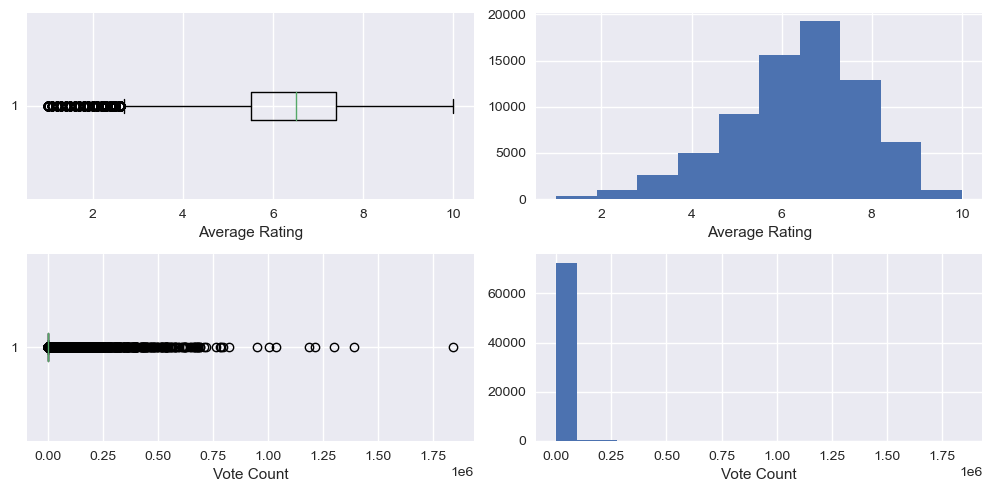

In [38]:
fig, ((ax_rating_box, ax_rating_hist), (ax_votes_box, ax_votes_hist)) = plt.subplots(
    nrows=2, ncols=2, figsize=(10,5))

# Top row
ax_rating_box.boxplot(movies_w_ratings_imdb['averagerating'], vert=False, )
ax_rating_box.set_xlabel('Average Rating')

ax_rating_hist.hist(movies_w_ratings_imdb['averagerating'])
ax_rating_hist.set_xlabel('Average Rating')

###

# Bottom row
ax_votes_box.boxplot(movies_w_ratings_imdb['numvotes'], vert=False)
ax_votes_box.set_xlabel('Vote Count')

ax_votes_hist.hist(movies_w_ratings_imdb['numvotes'], bins=20)
ax_votes_hist.set_xlabel('Vote Count')

plt.tight_layout(pad=1)
plt.savefig('./images/dist1.png', dpi=150);

**The distribution of vote counts is clearly very skewed.**

There's a disproportionate number of titles with low vote counts.

Taking a look at these titles.

In [39]:
mean_votes = movies_w_ratings_imdb['numvotes'].mean()
mean_votes

3564.0968895098

In [40]:
median_votes = movies_w_ratings_imdb['numvotes'].median()
median_votes

51.0

In [41]:
q90_votes = movies_w_ratings_imdb['numvotes'].quantile(.90)
q90_votes

1621.0

In [42]:
# Taking a look at the bottom 90 percent of movies
# in terms of number of votes

movies_w_ratings_imdb.query(f"numvotes < {q90_votes}").sample(10)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
40556,tt2448958,El jardín secreto,El jardín secreto,2012,80.0,Documentary,8.0,8.0
34121,tt2265641,Omar & Salma 3,Omar & Salma 3,2012,98.0,"Comedy,Romance",3.8,375.0
88667,tt5135256,Thy Father's Chair,Thy Father's Chair,2015,74.0,Documentary,8.2,67.0
31814,tt2200022,Truth in 24 II: Every Second Counts,Truth in 24 II: Every Second Counts,2012,83.0,Documentary,7.5,256.0
108277,tt6353186,Scar Lake,Scar Lake,2019,NaN,Thriller,7.6,7.0
82457,tt4746216,Pope,Pope,2017,55.0,"Crime,Drama",8.5,149.0
62191,tt3582084,2014,2014,2014,109.0,Action,7.1,33.0
109146,tt6414768,Ar Ma,Ar Ma,2016,NaN,"Comedy,Horror",4.9,20.0
67135,tt3822896,Treblinka,Treblinka,2016,61.0,"Drama,History",5.9,59.0
108341,tt6357342,Risky Drinking,Risky Drinking,2016,82.0,Documentary,6.6,218.0


**This is *most* of our current dataset. But again, we don't want niche, lesser-known titles to pollute our conclusions.** The reality is that in the film industry, a ton of content is made, and only a select few are known to the common viewer. We want our analysis to be based on the most well-known movies. A client like Microsoft will want to model its movie business on titles that have broad appeal or are at least well-known.

Below, we drop all movies from our current datasets except those whose number of votes is in the top 10 percent.

In [43]:
#Using a for loop again to drop these titles from the 3 datasets we're still using

for dataset in [
    clean_genres, 
    expl_clean_genres,
    movies_w_ratings_imdb
]:
    dataset.drop(
        index=dataset.query(f"numvotes < {q90_votes}").index, 
        inplace=True
    )

In [44]:
movies_w_ratings_imdb.shape

(7304, 8)

**We are left with a dataset with 7,304 movies. Let's look at those distributions again.**

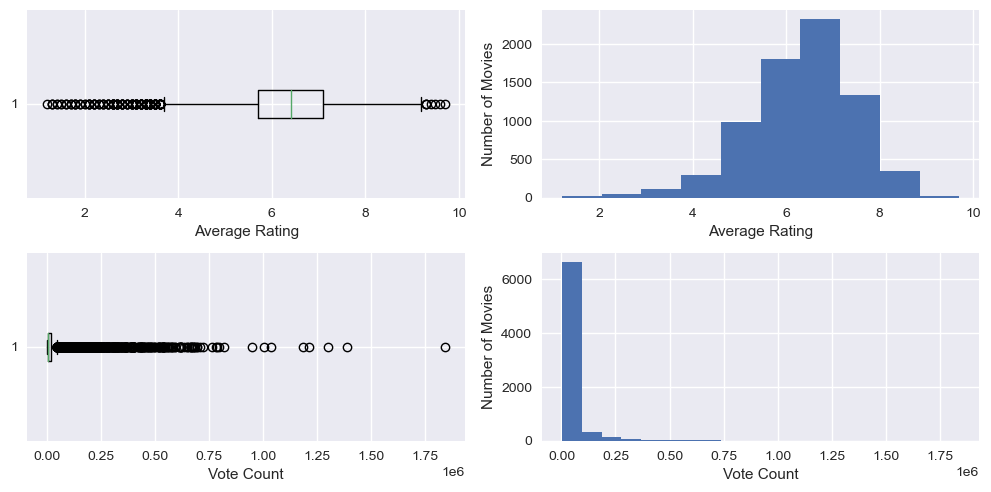

In [45]:
fig, ((ax_rating_box, ax_rating_hist), (ax_votes_box, ax_votes_hist)) = plt.subplots(
    nrows=2, ncols=2, figsize=(10,5))

# Top row
ax_rating_box.boxplot(movies_w_ratings_imdb['averagerating'], vert=False, )
ax_rating_box.set_xlabel('Average Rating')

ax_rating_hist.hist(movies_w_ratings_imdb['averagerating'])
ax_rating_hist.set_xlabel('Average Rating')
ax_rating_hist.set_ylabel('Number of Movies')

###

# Bottom row
ax_votes_box.boxplot(movies_w_ratings_imdb['numvotes'], vert=False)
ax_votes_box.set_xlabel('Vote Count')

ax_votes_hist.hist(movies_w_ratings_imdb['numvotes'], bins=20)
ax_votes_hist.set_xlabel('Vote Count')
ax_votes_hist.set_ylabel('Number of Movies')

plt.tight_layout(pad=1)
plt.savefig('./images/dist2.png', dpi=150);

**This *slightly* improved the workability of these distributions, but they're still skewed, even after we dumped most of the dataset.** This is going to be impossible to avoid due to the massive amount of content out there. 

Now, let's see what kind of relationship there is between number of votes and rating.

In [46]:
# Checking the correlation coefficient of average raring and number of votes

print('Correlation between number of votes and average rating: {}'.format(
    np.corrcoef(
        movies_w_ratings_imdb['numvotes'],
        movies_w_ratings_imdb['averagerating'])[0,1]
))

Correlation between number of votes and average rating: 0.2126063733913749


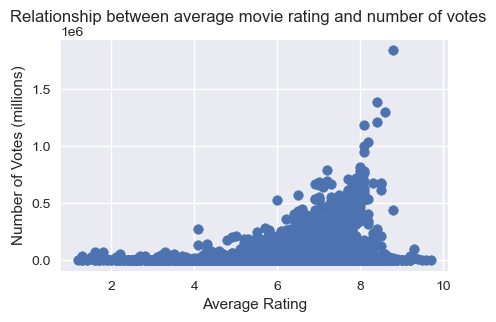

In [47]:
# Plotting the relationship between average rating and number of votes

fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(
    x=movies_w_ratings_imdb['averagerating'],
    y=movies_w_ratings_imdb['numvotes'],
)

ax.set_xlabel('Average Rating')
ax.set_ylabel('Number of Votes (millions)')
plt.suptitle('Relationship between average movie rating and number of votes')

plt.savefig('./images/scatter-votes-rating.png', dpi=150);

**There's a positive relationship between average rating and number of votes.**

I am inferring that a higher number of votes means that more people have seen the movie, regardless of the actual rating they voted for. I am also assuming that that Microsoft wants to make movies that are **more likely to be seen**, regardless of whether or not they're critically acclaimed.

**Therefore, our measure of success will be number of votes.** In choosing this as our measure of success, we are also reassured that that it's generally associated with a higher movie rating.

Because the distributions are skewed, we'll use median to measure the average.



## Question 1: 
### What are the top 10 genres Microsoft should focus on?

Below, we group movies by genre and see the medians of `numvotes` for each genre.

In [48]:
# Pivot table showing the average of numvotes by genre.

pivot_genres = pd.pivot_table(
    data=expl_clean_genres,
    values=['numvotes'],
    index='genres',
    aggfunc=np.median
).sort_values(by='numvotes', ascending=False).reset_index()

pivot_genres

,genres,numvotes
0,Adventure,16484.0
1,Fantasy,10546.0
2,Sci-Fi,10067.0
3,Animation,9354.0
4,Mystery,8494.0
5,Western,8284.5
6,Action,7543.5
7,Crime,7414.0
8,Biography,6560.0
9,Romance,6540.5


Now that we finally have aggregate measures based on genres, we can analyze which genres are most successful.

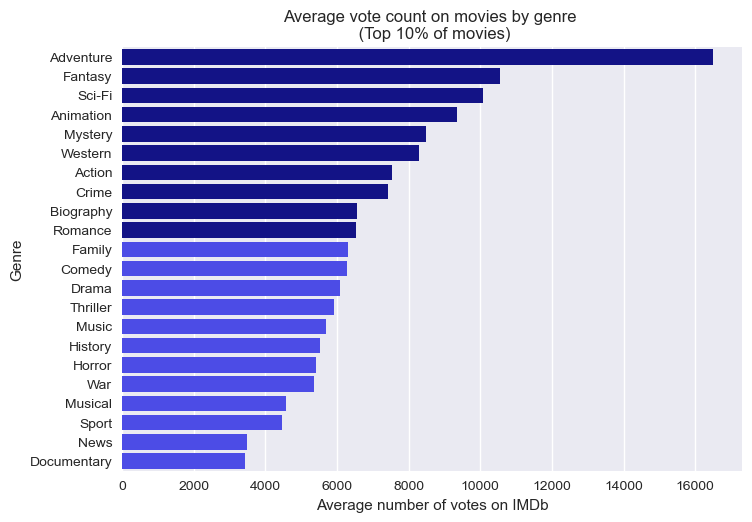

In [49]:
values = pivot_genres['numvotes']
labels = pivot_genres['genres']

genres_barplot = sns.barplot(
    x=values,
    y=labels,
    orient='h',
#     palette='crest_r'
    palette=['#000099' if (x > values[10]) else '#3333ff' for x in values]
    )

genres_barplot.set(
    xlabel='Average number of votes on IMDb',
    ylabel='Genre',
    title ='Average vote count on movies by genre \n (Top 10% of movies)'
    );

plt.savefig('./images/top_genres', dpi=150)

In [50]:
print('The top 10 genres in terms of average number of votes on IMDb are:')
print()
for g in pivot_genres.iloc[:10]['genres']:
    print(g)

The top 10 genres in terms of average number of votes on IMDb are:

Adventure
Fantasy
Sci-Fi
Animation
Mystery
Western
Action
Crime
Biography
Romance


#### The genres listed above are the best performing on IMDb.

That doesn't mean these genres perform well on their own. It's important to remember that we split up the genres before we did this analysis. That means a sci-fi movie that is also a comedy movie might also perform well.

**Conclusion 1:**
Microsoft should focus on movies that include combinations of the following genres:
- Adventure
- Fantasy
- Sci-Fi
- Animation
- Mystery
- Western
- Action
- Crime
- Biography
- Romance

--- 
---

## Question 2

### How much should Microsoft invest in comedies?

**Comedy fans might be dismayed by our first conclusion.** Comedy is a major genre that got wiped out due to the statistical analysis. But wat can we learn from comedies that are among the most successful movies?

Recall that our dataset is now essentially a subset that includes the top 10% of movies. Let's see how many of those are comedies.

We'll be working with our `clean_genres` dataset moving forward.

In [51]:
# Adding a column to clean_genres with a boolean value 
# based on whether the movie is a comedy or not

clean_genres['is_comedy'] = ['Comedy' in row for row in clean_genres['genres']]

In [52]:
clean_genres.sample(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,is_comedy
59998,tt3477752,Sweet Home,Sweet Home,2015,80.0,[Horror],5.2,1996.0,False
19266,tt1828970,Evidence,Evidence,2013,94.0,"[Crime, Mystery, Thriller]",5.4,6475.0,False
62989,tt3619772,Hate Story 2,Hate Story 2,2014,130.0,"[Drama, Thriller]",4.4,1871.0,False
725,tt1002563,The Young Messiah,The Young Messiah,2016,111.0,"[Drama, Fantasy]",5.6,2882.0,False
129871,tt8020896,An Elephant Sitting Still,Da xiang xi di er zuo,2018,230.0,[Drama],7.9,1976.0,False


In [53]:
# Of the top 10% of movies, how many movies are comedies?

comedy_breakdown = clean_genres['is_comedy'].value_counts()
comedy_breakdown

False    5023
True     2281
Name: is_comedy, dtype: int64

In [54]:
comedy_breakdown_norm = clean_genres['is_comedy'].value_counts(normalize=True)
comedy_breakdown_norm

False    0.687705
True     0.312295
Name: is_comedy, dtype: float64

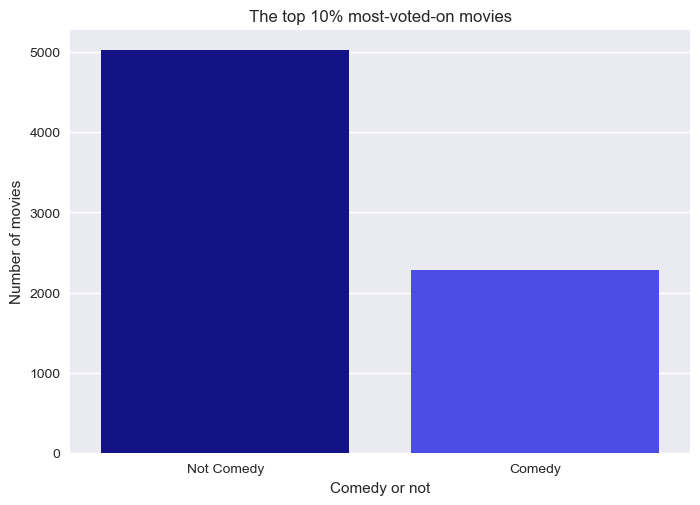

In [55]:
values = comedy_breakdown.values
labels = comedy_breakdown.index

comedy_plot = sns.barplot(
    x=labels,
    y=values,
    palette=['#000099' if x == False else '#3333ff' for x in labels]
    ).set(
    xlabel='Comedy or not',
    ylabel='Number of movies',
    xticklabels=['Not Comedy', 'Comedy'],
    title='The top 10% most-voted-on movies'
)

plt.savefig('./images/comedies', dpi=150)

**Of the top 10% best-performing movies, 2,281 out of 7,304 — or 31.22% — are comedies.**

**Conclusion 2:** Microsoft should focus about a third of its efforts (in terms of budget or number of movies) on making comedic movies.

---
---

## Question 3:

### Along the same lines as Question 2:
### How much should Microsoft invest in animated movies?

Repeating the process above for animated movies.

In [56]:
clean_genres['is_animated'] = ['Animation' in row for row in clean_genres['genres']]

In [57]:
animated_breakdown = clean_genres['is_animated'].value_counts()
animated_breakdown

False    7017
True      287
Name: is_animated, dtype: int64

In [58]:
animated_breakdown_norm = clean_genres['is_animated'].value_counts(normalize=True)
animated_breakdown_norm

False    0.960706
True     0.039294
Name: is_animated, dtype: float64

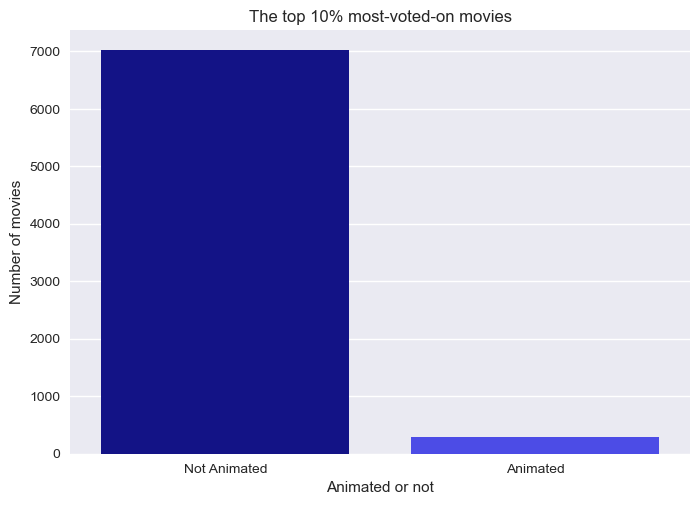

In [59]:
values = animated_breakdown.values
labels = animated_breakdown.index

animated_plot = sns.barplot(
    x=labels,
    y=values,
    palette=['#000099' if x == False else '#3333ff' for x in labels]
    ).set(
    xlabel='Animated or not',
    ylabel='Number of movies',
    xticklabels=['Not Animated', 'Animated'],
    title='The top 10% most-voted-on movies'
)
plt.savefig('./images/animated', dpi=150)

**Of the top 10% best-performing movies, 287 out of 7,304, — or 3.93% — are animated.**

**Conclusion 3:** Microsoft should focus about 4 percent of its efforts (in terms of budget or number of movies) on making animated movies.

## Recommendations

In this analysis I attemped to determine the most successful movie genres as well as what proportions of movies are comedies or animated. I arrived at three recommendations for what kinds of movies Microsoft should make:

1. Microsoft should focus its efforts on movies with some combination of these genres:

    - Adventure
    - Fantasy
    - Sci-Fi
    - Animation
    - Mystery
    - Western
    - Action
    - Crime
    - Biography
    - Romance
    
2. Microsoft should focus about a third of its efforts on comedy movies.

3. Microsoft should focus about 4 percent of its efforts on animated movies.